In [177]:
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
from scipy import linalg
from scipy.stats import norm
from scipy.stats import multivariate_normal
import itertools
%matplotlib inline

### Stochastic Backpropagation through Mixture Density Distributions
#### A Note by Alex Graves (https://arxiv.org/abs/1607.05690)

Recent methods for scalable, non-conjugate Bayesian inference have exploited non-centered parametrizations to take derivatives through Monte Carlo expectations.  For example, a sample from the Gaussian distribution $N(x; \mu_{\phi},\sigma_{\phi}^{2})$ can be drawn via the location-scale form: $$ x = \mu_{\phi} + \sigma_{\phi} \epsilon $$ $$ \text{ where } \epsilon \sim N(0,1).$$  Because there is a direct computation path between $x$ and the Gaussian's parameters, the derivatives $\partial x / \partial \mu_{\phi}$ and $\partial x / \partial \sigma_{\phi}$ can be computed.  Unfortunately, many distributions, including discrete ones, do not admit such a representation for sampling.  Graves's note discusses how to exploit the multivariate quantile transform to take derivatives through a sample from a mixture density.

### Example Model

Let's demonstrate Graves's method by performing stochastic inference for the following model: $$z \sim \sum_{k=1}^{2} \pi_{k} N(\mu_{k},\sigma_{k}^{2})$$ $$ x \sim N(z,\sigma_{0}^{2}). $$  That is, we'll have a mixture density prior on the mean parameter of a Normal distribution.  We want to compute its expected negative log likelihood $\mathcal{L} = \mathbb{E}_{p(z)}[- \log p(x|z)]$ (as we would do for EM or VI) and the derivative $\partial \mathcal{L} / \partial \pi_{k}$. 

Let's start by defining the necessary pdf's and cdf's...

In [178]:
# z: latent variable that we draw from mixture of Normals
# x: observed variable (data) modeled with a Normal dist.

# Component CDF F^k(z)
def F_k(z, d, k, mu_arr, cov_arr):
    return norm(loc=mu_arr[k][d], scale=np.sqrt(cov_arr[k][d,d])).cdf(z[d])

# Component PDF f^k(z)
def f_k(z, d, k, mu_arr, cov_arr):
    return norm(loc=mu_arr[k][d], scale=np.sqrt(cov_arr[k][d,d])).pdf(z[d])

# Mixture PDF f(z)
def f(z, d, pi_arr, mu_arr, cov_arr):
    p = 0.
    for k in xrange(len(mu_s)):
        p += pi_arr[k] * norm(loc=mu_arr[k][d], scale=np.sqrt(cov_arr[k][d,d])).pdf(z[d])
    return p

# d log f / dz, derivative of log of mix. component 
def dlogf_dz(z, mu, var):
    return -(z - mu) / var

# -log g(x|z) (loss function)
def g(x, z):
    return .5*np.sum((x-z)**2)

# d -log g(x|z) / dz
def dg_dz(x, z):
    return z - x

# Draw sample from mixture model
# k ~ Mult(pi)
# z ~ f_k
def draw_sample(pi_arr, mu_arr, cov_arr):
    k = np.argmax(np.random.multinomial(1, pi_arr))
    z = np.random.multivariate_normal(mu_s[k], cov_s[k])
    return z

Now we can define the full gradient computation...

In [179]:
def compute_dh_dpi(x, pi, mu_arr, cov_arr, j, N=1):
    # x: observed data
    # pi: mixture weights
    # mu_arr: list of numpy arrays containing component means
    # cov_arr: list of numpy arrays containing component covariance matrices
    # j: index of mixture weight in derivative, ie dz/d pi_j
    # N: number of samples for MC expectation

    # assumes 2D, diagonal covariance
    # h is the expected loss E[-log pdf]
    # g is the loss -log pdf
    
    dh_dpi_j = 0.

    # MC samples loop
    for n in xrange(N):

        # draw sample
        z = draw_sample(pi, mu_arr, cov_arr)

        # set p^k_1 vector
        p_k = np.array([pi[0], pi[1]])
        
        # set d log p / d pi_j
        dlog_p_dpi = [0., 0] 
        dlog_p_dpi[j] = 1./p_k[j]
        
        # set f_1
        f_z = [f(z, 0, p_k, mu_arr, cov_arr)]
        
        # dz/d pi
        dz_dpi = [ -F_k(z, 0, j, mu_arr, cov_arr) / f_z[0] ]

        # loop over dimensions
        for d in xrange(1,len(mu_arr)):
            
            # compute f_d
            f_z.append( f(z, d, p_k, mu_arr, cov_arr) ) 
    
            # compute p^k_d
            p_k = p_k * np.array( [f_k(z, d-1, 0, mu_arr, cov_arr), f_k(z, d-1, 1, mu_arr, cov_arr)] ) / f_z[d-1] 
    
            # compute d log p / d pi_j
            term2 = np.sum(p_k * dlog_p_dpi)
            partial_d_logf = np.array([dlogf_dz(z[d-1], mu_s[0][d-1], cov_s[0][d-1, d-1]), dlogf_dz(z[d-1], mu_s[1][d-1], cov_s[1][d-1, d-1])])
            term3 = dz_dpi[d-1] * (partial_d_logf - np.sum( p_k * partial_d_logf ))
            dlog_p_dpi = dlog_p_dpi - term2 + term3
    
            # compute dz/d pi
            F_vec = np.array([F_k(z, d, 0, mu_arr, cov_arr), F_k(z, d, 1, mu_arr, cov_arr)])
            dz_dpi.append( (-1./f_z[-1]) * np.sum(dlog_p_dpi * p_k * F_vec) )
    
        dh_dpi_j += np.sum( dg_dz(x, z) * np.array(dz_dpi) )

    # normalized by num. of MC samples
    dh_dpi_j /= N
    
    return dh_dpi_j

Lastly, we can run an example to see if the weights change accordingly.  First, let's make a function to visualize the mixture.  Plot the (spherical) Gaussians such that their transparency corresponds to the mixture weight.

In [185]:
def plot_mixture(x, pi, mu_arr, cov_arr):
    color_iter = itertools.cycle(['r', 'b', 'c', 'g'])
    fig = plt.figure(0)
    ax = fig.add_subplot(111, aspect='equal')
    for i, (weight, mean, covar, color) in enumerate(zip(pi, mu_arr, cov_arr, color_iter)):
        e = matplotlib.patches.Ellipse(mean, 5*covar[0,0], 5*covar[1,1], 180)
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(weight)
        e.set_facecolor(color)
    ax.scatter([x[0]], [x[1]], s=100, color='k', marker='x', label="data")
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.legend()
    plt.show()

Define the mixture and one data point $x$...

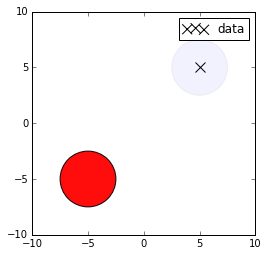

In [190]:
# define mixture weights
pi = np.array([.95, .05])

# define base dists.
mu_s = [np.array([-5., -5.]), np.array([5., 5.])]
cov_s = [np.array([[1., 0.], [0., 1.]]), np.array([[1., 0.], [0., 1.]])]

# data
x = np.array([5., 5.])

# plot mixture
plot_mixture(x, pi, mu_s, cov_s)

Neg. Log Likelihood: 95.4075188787
Mix. Weights: [ 0.95  0.05]

Neg. Log Likelihood: 97.0661665421
Mix. Weights: [ 0.9364266  0.0635734]

Neg. Log Likelihood: 91.944410067
Mix. Weights: [ 0.91367366  0.08632634]

Neg. Log Likelihood: 88.9340407001
Mix. Weights: [ 0.87226175  0.12773825]

Neg. Log Likelihood: 75.9311758406
Mix. Weights: [ 0.85966131  0.14033869]

Neg. Log Likelihood: 80.9892030972
Mix. Weights: [ 0.8291882  0.1708118]

Neg. Log Likelihood: 0.979776396029
Mix. Weights: [  5.60362280e-04   9.99439638e-01]

Neg. Log Likelihood: 1.03616291851
Mix. Weights: [  9.83218733e-05   9.99901678e-01]

Neg. Log Likelihood: 1.92696959019
Mix. Weights: [ 0.02084581  0.97915419]

Neg. Log Likelihood: 1.01813435279
Mix. Weights: [  1.00758005e-04   9.99899242e-01]

Neg. Log Likelihood: 1.08236583791
Mix. Weights: [  8.46042448e-04   9.99153958e-01]

Neg. Log Likelihood: 1.0089187026
Mix. Weights: [  8.55168825e-05   9.99914483e-01]

Neg. Log Likelihood: 0.967300433693
Mix. Weights: [  9.

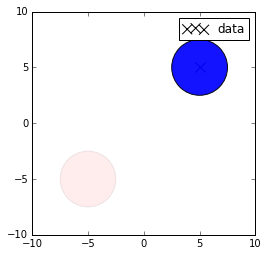

In [191]:
# constrain pi's to be a proper mixture
def constrain_pi(pi):
    if pi[0] <= 0:
        pi[0] = 0.0001
    if pi[1] <= 0:
        pi[1] = 0.0001
    
    # re-normalize
    pi /= np.sum(pi)
    
    return pi

# run SGD on the pi's 
epochs = 20
for idx in xrange(epochs):
    
    mc_loss = 0.
    M = 100
    for i in xrange(M):
        z = draw_sample(pi, mu_s, cov_s)
        mc_loss += g(x, z)
    print "Neg. Log Likelihood: "+str(mc_loss/M)
    print "Mix. Weights: "+str(pi)
    
    #update
    pi[0] -= .005 * compute_dh_dpi(x, pi=pi, mu_arr=mu_s, cov_arr=cov_s, j=0, N=100)
    constrain_pi(pi=pi)
    pi[1] -= .005 * compute_dh_dpi(x, pi=pi, mu_arr=mu_s, cov_arr=cov_s, j=1, N=100)
    constrain_pi(pi=pi)
    
    print
    
# and plot the mixture again
plot_mixture(x, pi, mu_s, cov_s)